In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tinashri/brain-tumor-dataset-includes-the-mask-and-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-dataset-includes-the-mask-and-images


In [2]:
DATA_DIR = "/kaggle/input/brain-tumor-dataset-includes-the-mask-and-images"

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


2026-01-27 15:52:40.875691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769529161.095328      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769529161.147682      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cell 2

In [3]:
IMG_SIZE = 128

def load_images_masks(img_dir, mask_dir):
    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    images = []
    masks = []
    
    for img_file, mask_file in zip(img_files, mask_files):
        # Load image
        img = load_img(os.path.join(img_dir, img_file), target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0
        # Load mask
        mask = load_img(os.path.join(mask_dir, mask_file), target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

# Correct dataset paths
DATA_DIR = "/kaggle/input/brain-tumor-dataset-includes-the-mask-and-images/data/data"
images, masks = load_images_masks(os.path.join(DATA_DIR, "images"),
                                  os.path.join(DATA_DIR, "masks"))

print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")


Images shape: (3064, 128, 128, 3), Masks shape: (3064, 128, 128, 1)


cell 3

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.1, random_state=42
)

print(f"Training images: {X_train.shape}, Training masks: {y_train.shape}")
print(f"Testing images: {X_test.shape}, Testing masks: {y_test.shape}")


Training images: (2757, 128, 128, 3), Training masks: (2757, 128, 128, 1)
Testing images: (307, 128, 128, 3), Testing masks: (307, 128, 128, 1)


In [5]:
from tensorflow.keras import layers, models, optimizers


def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D((2,2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D((2,2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_unet()
model.summary()


I0000 00:00:1769529219.115392      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, Concatenate

def build_discriminator(img_shape=(128,128,3), mask_shape=(128,128,1)):
    # Input: image + mask
    img_input = Input(shape=img_shape)
    mask_input = Input(shape=mask_shape)

    x = Concatenate()([img_input, mask_input])  # combine channels

    x = Conv2D(64, 4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, 4, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation='sigmoid')(x)  # real/fake

    model = Model([img_input, mask_input], out, name="Discriminator")
    model.compile(optimizer=optimizers.Adam(2e-4, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 4)                │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │      4,160 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv2d_21[0][0]   │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_22[0][0]   │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 131072)    │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │    131,073 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,888,641 (11.02 MB)

 Trainable params: 2,888,641 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # you can increase later
    batch_size=8
)


Epoch 1/10


I0000 00:00:1769529230.307603      58 service.cc:148] XLA service 0x7b0910002be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769529230.308198      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769529231.199601      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/345 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.5123 - loss: 0.6922   

I0000 00:00:1769529241.895704      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


344/345 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9717 - loss: 0.1457

E0000 00:00:1769529271.642663      58 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1769529271.887972      58 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9718 - loss: 0.1455

E0000 00:00:1769529284.529423      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1769529284.774456      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


345/345 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.9718 - loss: 0.1453 - val_accuracy: 0.9830 - val_loss: 0.0579
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9828 - loss: 0.0547 - val_accuracy: 0.9871 - val_loss: 0.0401
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9867 - loss: 0.0390 - val_accuracy: 0.9886 - val_loss: 0.0322
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9896 - loss: 0.0289 - val_accuracy: 0.9902 - val_loss: 0.0282
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9912 - loss: 0.0238 - val_accuracy: 0.9914 - val_loss: 0.0232
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9923 - loss: 0.0202 - val_accuracy: 0.9915 - val_loss: 0.0234
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9932 - loss: 0.0176 - val_accuracy: 0.9908 - val_loss: 0.0275
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9940 - loss: 0.0153 - val_accura

2026-01-27 15:59:06.331458: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,128,128]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2026-01-27 15:59:06.345094: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.013741096s
Trying algorithm eng12{k11=2} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,128,128]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

E0000 00:00:1769529552.189115      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1769529552.439041      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 762ms/step


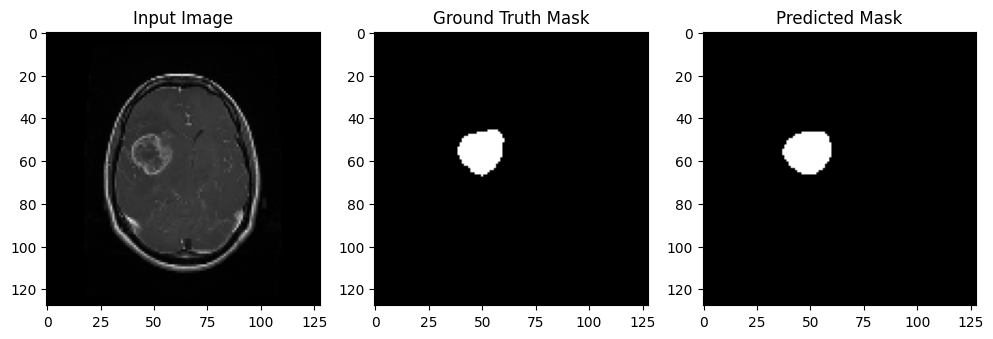

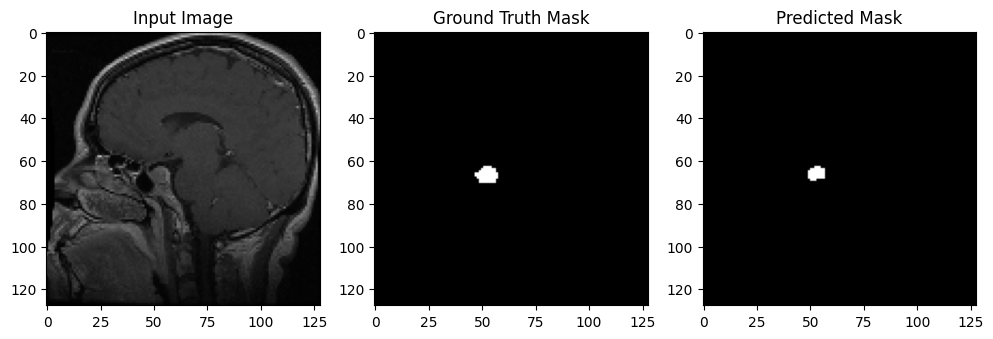

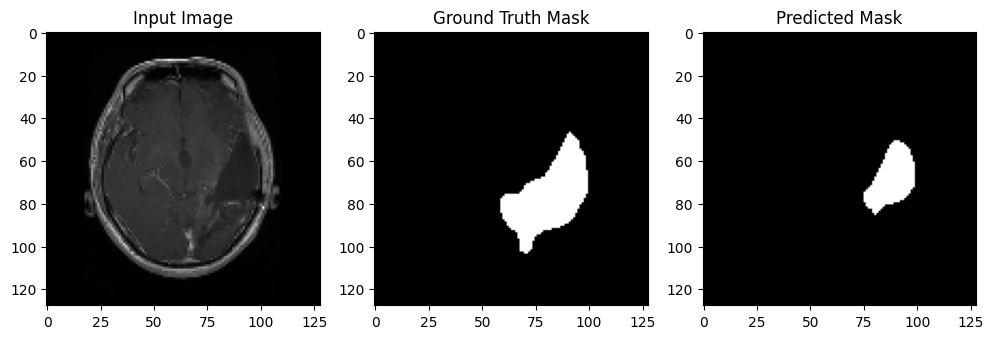

In [8]:
# Generate predictions
preds = model.predict(X_test)
preds = (preds > 0.5).astype(np.uint8)

# Visualize first 3 examples
for i in range(3):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()


In [9]:
import numpy as np

# Predict masks for test images
preds = (model.predict(X_test) > 0.5).astype(np.uint8)

# Dice coefficient function
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Compute Dice for each test image
dice_scores = [dice_score(y_test[i], preds[i]) for i in range(len(y_test))]
mean_dice = np.mean(dice_scores)
print("Mean Dice score on test set:", mean_dice)



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Mean Dice score on test set: 0.7408916709155469


In [10]:
def detect_tumor(model, image, threshold=0.5, show=True):
    """
    Predict tumor mask for one image and print tumor status.
    """
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    binary_mask = (pred_mask > threshold).astype(np.uint8)

    if np.sum(binary_mask) == 0:
        print("No tumor found.")
    else:
        print("Tumor detected!")

    if show:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap="gray")
        plt.axis("off")
        

        plt.subplot(1, 3, 3)
        plt.title("Thresholded Mask")
        plt.imshow(binary_mask, cmap="gray")
        plt.axis("off")

        plt.show()


In [11]:
model.save("meramodel.h5")
print("Model saved locally as mymodel.h5")


Model saved locally as mymodel.h5
